# Vehicle Detection Project

### Dependencies

In [1]:
import os
import numpy as np
import imp
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from vehicle_lib.config import *
from vehicle_lib import feature_extract
from vehicle_lib import utils
from vehicle_lib import window
from vehicle_lib import heatmap
from vehicle_lib.feature_extract import single_img_features
from vehicle_lib import vehicle_detect

from moviepy.editor import VideoFileClip

In [2]:
# imp.reload(utils)
# imp.reload(heatmap)
# imp.reload(window)
# imp.reload(vehicle_detect)

### Data Exploration

In [3]:
vehicle_files_path = './data/vehicles/'
non_vehicle_files_path = './data/non-vehicles/'

# Load vehicle and non-vehicle images from fs to memory
vehicle_files = utils.get_images_recursively(vehicle_files_path)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = utils.get_images_recursively(non_vehicle_files_path)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files]

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Number of vehicle files: 8792
Number of non-vehicle files: 8968


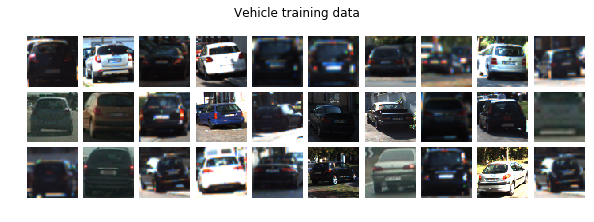

In [4]:
utils.display_images(vehicle_files, n_images=30, n_rows=10, title='Vehicle training data')

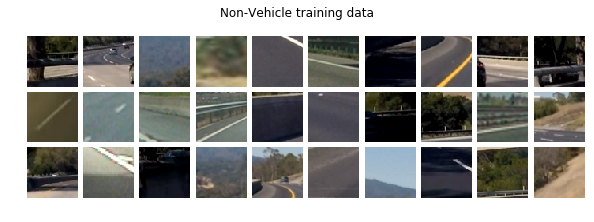

In [5]:
utils.display_images(non_vehicle_files, n_images=30, n_rows=10, title='Non-Vehicle training data')

### Histogram of Oriented Gradients (HOG) features

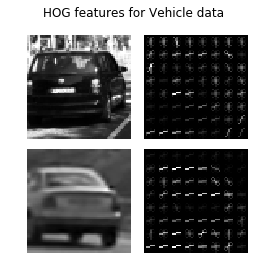

In [6]:
vehicles = []
hog_features = []

for i in range(2):
    rand_idx = np.random.randint(1, len(vehicle_files))
    img = mpimg.imread(vehicle_files[rand_idx])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    features, hog_image = feature_extract.get_hog_features(img_gray, 
                                                           orient=9, 
                                                           pix_per_cell=8, 
                                                           cell_per_block=2, 
                                                           vis=True, 
                                                           feature_vec=False)
    
    vehicles.append(img_gray)
    hog_features.append(hog_image)

# Display HOG features for Vehicle data
utils.display_features(hog_features, vehicles, color_map='gray', suptitle='HOG features for Vehicle data')

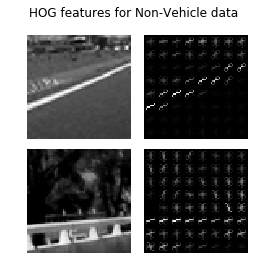

In [7]:
vehicles = []
hog_features = []

for i in range(2):
    rand_idx = np.random.randint(1, len(non_vehicle_files))
    img = mpimg.imread(non_vehicle_files[rand_idx])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    features, hog_image = feature_extract.get_hog_features(img_gray, 
                                                           orient=9, 
                                                           pix_per_cell=8, 
                                                           cell_per_block=2, 
                                                           vis=True, 
                                                           feature_vec=False)
    
    vehicles.append(img_gray)
    hog_features.append(hog_image)

# Display HOG features for Non-Vehicle data
utils.display_features(hog_features, vehicles, color_map='gray', suptitle='HOG features for Non-Vehicle data')

In [8]:
rand_idx = np.random.randint(1, len(vehicle_files))
test_img = mpimg.imread(vehicle_files[rand_idx])
# test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#4) Extract features for that window using single_img_features()
features = single_img_features(test_img, color_space=config['color_space'], 
                                spatial_size=config['spatial_size'], hist_bins=config['hist_bins'], 
                                orient=config['orient'], pix_per_cell=config['pix_per_cell'], 
                                cell_per_block=config['cell_per_block'], 
                                hog_channel=config['hog_channel'], spatial_feat=config['spatial_feat'], 
                                hist_feat=config['hist_feat'], hog_feat=config['hog_feat'])

### Colour Space

In [9]:
def plot_histogram(img, nbins=32, bins_range=(0, 256), title=''):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Plot a figure with all three bar charts
    if channel1_hist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch1 Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch2 Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch3 Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

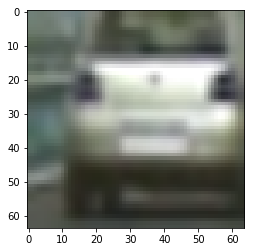

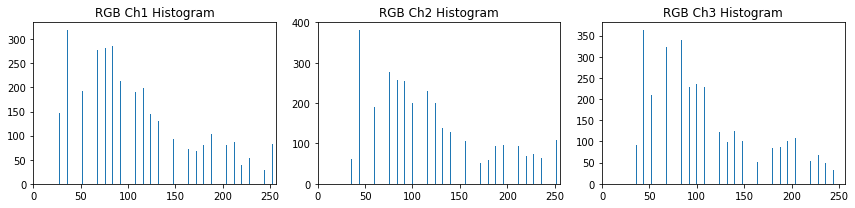

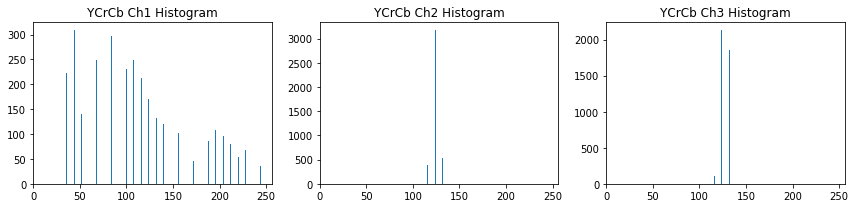

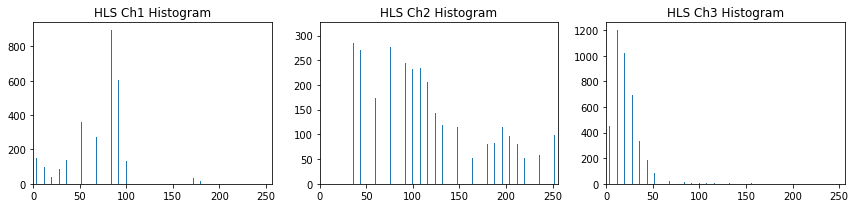

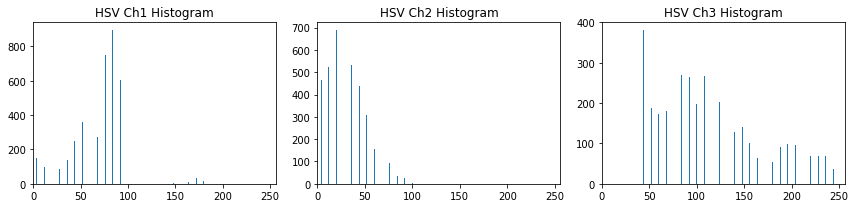

In [10]:
# rand_idx = np.random.randint(1, len(vehicle_files))
idx = 100
c_image = cv2.imread(vehicle_files[idx])
plt.imshow(c_image)
plt.show()
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_BGR2RGB), title='RGB')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_BGR2YCrCb), title='YCrCb')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_BGR2HLS), title='HLS')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_BGR2HSV), title='HSV')

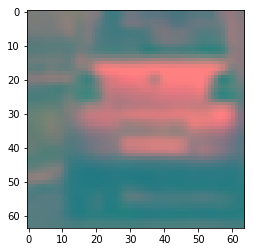

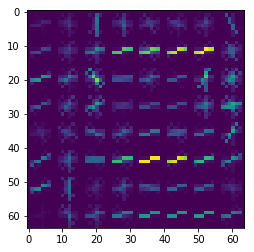

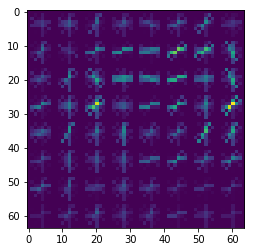

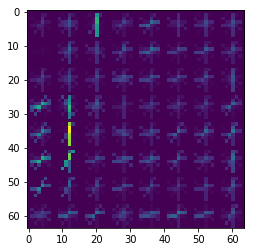

In [11]:
img = mpimg.imread(vehicle_files[1])
img = cv2.cvtColor(c_image, cv2.COLOR_BGR2YCrCb)
plt.figure()
plt.imshow(img)
for i in range(3):
    features, hog_image = feature_extract.get_hog_features(img[:,:,i],
                                                           orient=9, 
                                                           pix_per_cell=8, 
                                                           cell_per_block=2, 
                                                           vis=True, 
                                                           feature_vec=False)
    plt.figure()
    plt.imshow(hog_image)

### Sliding-window technique

Image shape:  (720, 1280, 3)


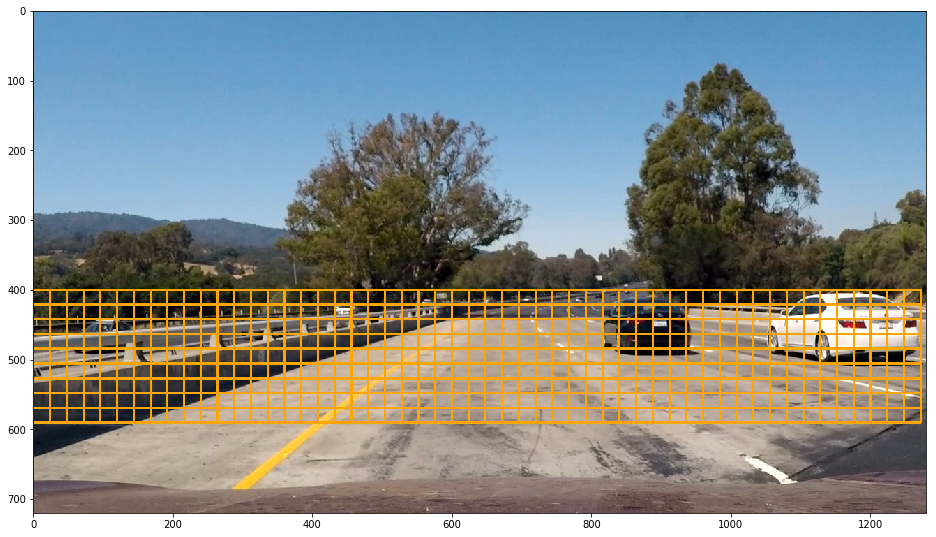

In [12]:
img_path = './test_images/test1.jpg'
img = mpimg.imread(img_path)

print("Image shape: ", img.shape)
slided_windows = window.slide_window(img, xy_window=config['xy_window'], 
                                     xy_overlap=config['xy_overlap'], y_start_stop=config['y_start_stop'])
img = window.draw_sliding_windows(img, slided_windows, color=(255, 165, 0), thick=2)
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.show()

### Configuration

In [13]:
config = {
    'color_space'       : 'YCrCb',          # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient'            : 9,                # HOG orientations
    'pix_per_cell'      : 8,                # HOG pixels per cell
    'cell_per_block'    : 2,                # HOG cells per block
    'hog_channel'       : 'ALL',            # Can be 0, 1, 2, or "ALL"
    'spatial_size'      : (32, 32),         # Spatial binning dimensions
    'hist_bins'         : 32,               # Number of histogram bins
    'spatial_feat'      : True,             # Spatial features on or off
    'hist_feat'         : True,             # Histogram features on or off
    'hog_feat'          : True,             # HOG features on or off
    'x_start_stop'      : [None, None],
    'y_start_stop'      : [400, 600],
    'xy_window'         : (96, 85),
    'xy_overlap'        : (0.75, 0.75),
    'heat_threshold'    : 15
};

### Scaling and SVM Classifier Pipeline, Training and Validation

In [14]:
# Extract features for vehicle and non-vehicle images
vehicle_features = feature_extract.extract_features(vehicle_images, 
                                                    config['color_space'], 
                                                    config['spatial_size'], 
                                                    config['hist_bins'], 
                                                    config['orient'], 
                                                    config['pix_per_cell'], 
                                                    config['cell_per_block'], 
                                                    config['hog_channel'], 
                                                    config['spatial_feat'], 
                                                    config['hist_feat'], 
                                                    config['hog_feat'])
print('Shape of the vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = feature_extract.extract_features(non_vehicle_images, 
                                                        config['color_space'], 
                                                        config['spatial_size'], 
                                                        config['hist_bins'], 
                                                        config['orient'], 
                                                        config['pix_per_cell'], 
                                                        config['cell_per_block'], 
                                                        config['hog_channel'], 
                                                        config['spatial_feat'], 
                                                        config['hist_feat'], 
                                                        config['hog_feat'])
print('Shape of the non-vehicle features: {}'.format(non_vehicle_features.shape))
    
# Prepare vehicle and non-vehicle features from training images
X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
y_features = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

# Split images into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                                    test_size=0.25, random_state=1024)

# Initalise pipeline of Standard Scaler and Linear SVM classifier
pipeline = Pipeline([('scaling', StandardScaler(with_mean=0, with_std=1)),
                     ('classifier', SVC(kernel='linear'))])

# Train classifier
pipeline.fit(X_train, y_train)

# Measure validation accuracy
accuracy = pipeline.score(X_test, y_test)
print('Validation accuracy: {:.4f}'.format(accuracy))

Shape of the vehicle features: (8792, 8460)
Shape of the non-vehicle features: (8968, 8460)
Validation accuracy: 0.9903


In [17]:
print(pipeline)

Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=0, with_std=1)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


### Classifier detection (Test 1 image)

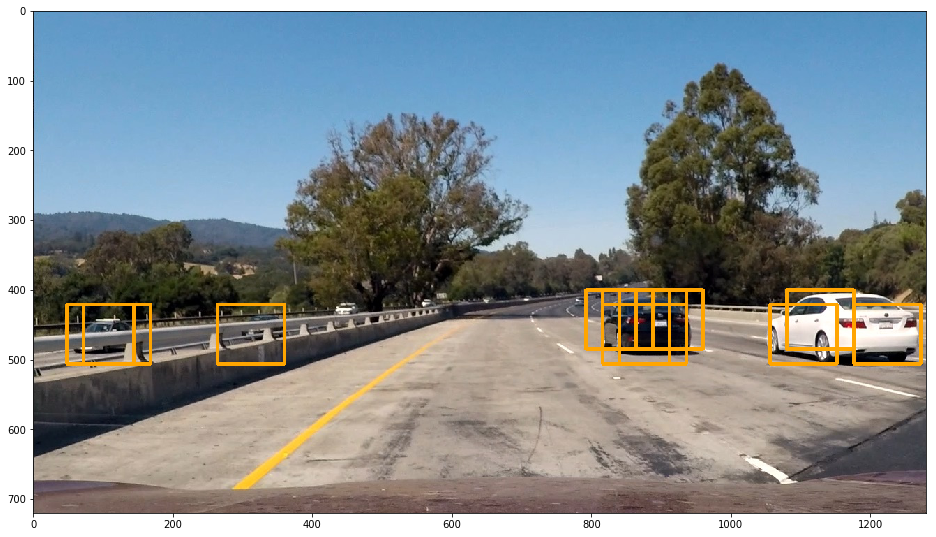

In [32]:
img_path = './test_images/test1.jpg'
input_image = mpimg.imread(img_path)
img = np.copy(input_image).astype(np.float32) / 255.

slided_windows = window.slide_window(img, xy_window=config['xy_window'], 
                                     xy_overlap=config['xy_overlap'], y_start_stop=config['y_start_stop'])

on_windows = window.search_windows(img, slided_windows, pipeline,
                                   color_space=config['color_space'], spatial_size=config['spatial_size'],
                                   hist_bins=config['hist_bins'], orient=config['orient'],
                                   pix_per_cell=config['pix_per_cell'], cell_per_block=config['cell_per_block'],
                                   hog_channel=config['hog_channel'], spatial_feat=config['spatial_feat'],
                                   hist_feat=config['hist_feat'], hog_feat=config['hog_feat'])

window_img = window.draw_sliding_windows(np.copy(input_image), on_windows, color=(255, 165, 0), thick=3)

# Visualise detections
plt.figure(figsize=(16, 10))
plt.imshow(window_img)
plt.show()

### Heat Map (Test 1 image)

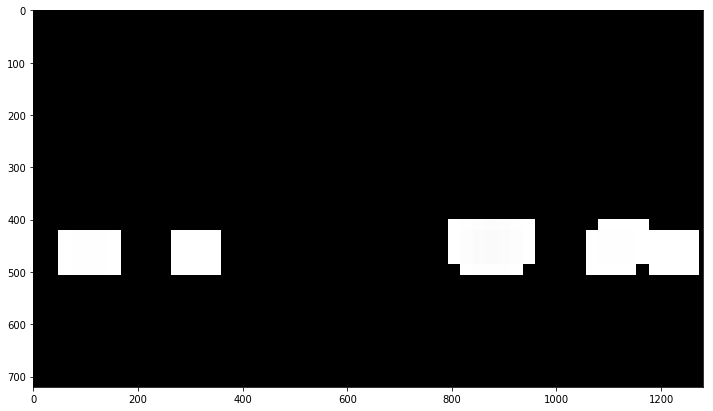

In [33]:
stable_heatmaps = heatmap.StableHeatMaps(threshold=0, num_frames=1)
heat_map = stable_heatmaps.generate(img, on_windows)
# Visualise Heat map
plt.figure(figsize=(12, 8))
plt.imshow(heat_map, cmap='hot')

### Bounding Boxes over heatmap (Test 1 image)

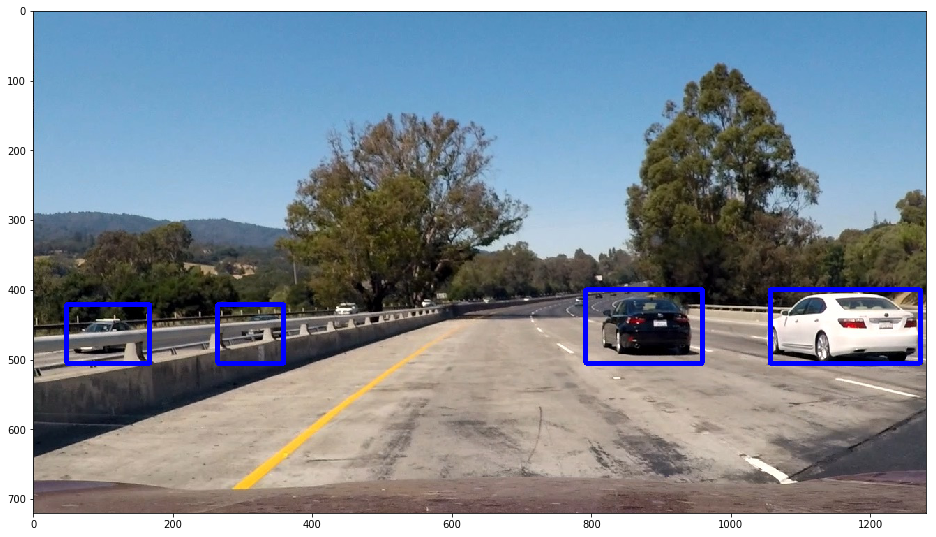

In [35]:
labels = label(heat_map)
image_with_bb = window.draw_labeled_bboxes(input_image, labels)

# Visualise detections
plt.figure(figsize=(16, 10))
plt.imshow(image_with_bb)
plt.show()

### Classifier detection (Test 4 image)

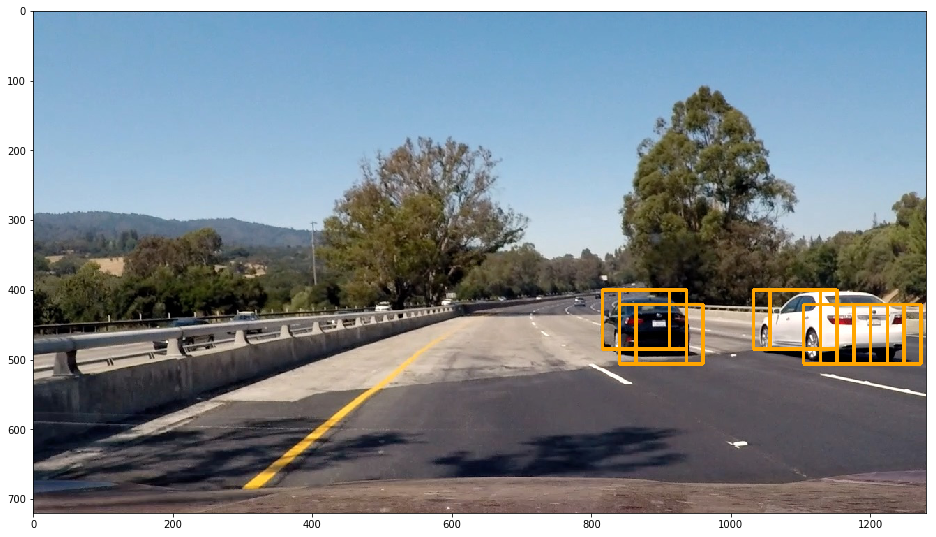

In [27]:
img_path = './test_images/test4.jpg'
input_image = mpimg.imread(img_path)
img = np.copy(input_image).astype(np.float32) / 255.

slided_windows = window.slide_window(img, xy_window=config['xy_window'], 
                                     xy_overlap=config['xy_overlap'], y_start_stop=config['y_start_stop'])

on_windows = window.search_windows(img, slided_windows, pipeline,
                                   color_space=config['color_space'], spatial_size=config['spatial_size'],
                                   hist_bins=config['hist_bins'], orient=config['orient'],
                                   pix_per_cell=config['pix_per_cell'], cell_per_block=config['cell_per_block'],
                                   hog_channel=config['hog_channel'], spatial_feat=config['spatial_feat'],
                                   hist_feat=config['hist_feat'], hog_feat=config['hog_feat'])

window_img = window.draw_sliding_windows(np.copy(input_image), on_windows, color=(255, 165, 0), thick=3)

# Visualise detections
plt.figure(figsize=(16, 10))
plt.imshow(window_img)
plt.show()

### Heat Map (Test 4 image)

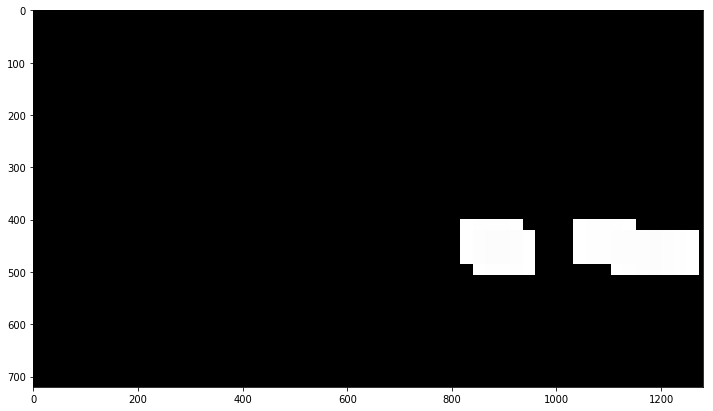

In [28]:
stable_heatmaps = heatmap.StableHeatMaps(threshold=0, num_frames=1)
heat_map = stable_heatmaps.generate(img, on_windows)
# Visualise Heat map
plt.figure(figsize=(12, 8))
plt.imshow(heat_map, cmap='hot')

### Bounding boxes over heatmap (Test 4 image)

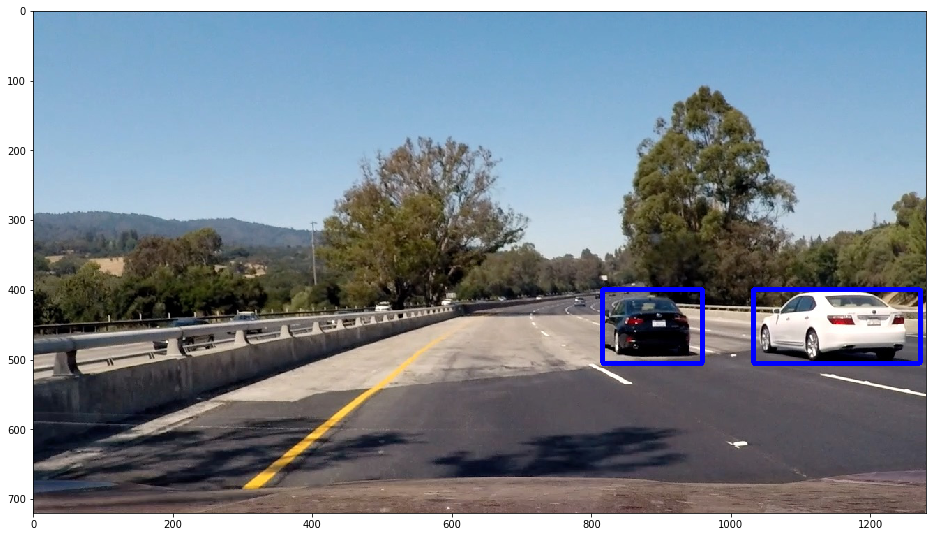

In [29]:
labels = label(heat_map)
image_with_bb = window.draw_labeled_bboxes(input_image, labels)

# Visualise detections
plt.figure(figsize=(16, 10))
plt.imshow(image_with_bb)
plt.show()

In [69]:
from moviepy.editor import *
clip = (VideoFileClip("annotated_project_video.mp4")
            .crop(y1=config['y_start_stop'][0] - 30, y2=config['y_start_stop'][1] + 30) # crop to sliding-window roi
            .resize(0.5)
            .subclip(29.4, 42.0))
clip.write_gif("output_images/overview.gif")
#             .speedx(0.5)


[MoviePy] Building file output_images/overview.gif with imageio


100%|██████████| 316/316 [00:04<00:00, 68.38it/s]


In [71]:
from IPython.display import Image
Image(url='output_images/overview.gif')